In [1]:
import pandas as pd
import numpy as np

from math import *
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm  # для построения qq plot
from scipy.stats import norm, normaltest
import seaborn as sns


In [2]:
sale = pd.read_excel('/Users/kateosti/Desktop/beaty_city/Test/01_sales_ToShare.xlsx')
leftover = pd.read_excel('/Users/kateosti/Desktop/beaty_city/Test/01_leftover _ToShare.xlsx')

Посмотрим данные

## Первая таблица Продаж: обработка данных 

In [3]:
sale

,Артикул старый,Размер,Месяц,"Продажи, шт."
0,02025727Y052D0/55,XS,9,88
1,02025727Y052D0/55,S,6,128
2,020245D5Z022/55D0,M,7,83
3,020245D5Z022/55D0,M,9,68
4,020245D5Z022/55D0,L,6,74
...,...,...,...,...
60069,92011936231500/99,L,12,62
60070,92011936231500/99,M,12,74
60071,92014947Q62500/29,0,12,64
60072,92021936J09500/01,M,12,73


In [4]:
# Переименую столбцы для удобства и чтобы вернуть копию на русском возьму set_axis
df = sale.set_axis(['new_art', 'size', 'month', 'sales'], axis=1, inplace=False)

In [5]:
# Новые названия столбцов
df.columns

Index(['new_art', 'size', 'month', 'sales'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60074 entries, 0 to 60073
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   new_art  60074 non-null  object
 1   size     60074 non-null  object
 2   month    60074 non-null  int64 
 3   sales    60074 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ MB


1. Предобработка данных:

Статистика продаж на WB - файл "Задание01_Продажи_ToShare"     
Артикул старый - код цветомоделей, но в старом формате. ВАЖНО, он отличается нового формата артикулов, а именно    
•	Если он выглядит вот так (т.е. без знака "/"): "21022322U1535900", то тогда он является новым артикулом цветомодели      
•	Если знак "/" на 13 позиции, например: "020245D5Z022/55D0", то тогда новый артикул цветомодели из него получается простым удалением символа "/", т.е. в нашем случае это будет ""020245D5Z02255D0""      
•	А если знак "/" на 15 позиции, например: "02025727Y052D0/55", то тогда новый артикул цветомодели можно получить как "Левые 12 символов + правые два символа + два символа на позиция 13 и 14", т.е. в нашем случае это "02025727Y05255D0"      
•	Есть несколько «ошибочных» позиций, у которых знак «/» на 17 позиции, в таком случае надо просто взять 16 левых символов     
•	Размер — это размер одежды, в случае если размера нет ("no size"), то это кодируется "0" в данной выгрузке     
•	Месяц - порядковый месяц, в котором были совершены продажи     
•	Продажи, шт. - число проданных единиц за указанный месяц    
•	ВАЖНО: не по всем артикулам есть информация по остаткам/цене продажи/себестоимости, по таким позициям считать, что Их остаток равен 0    
•	Себестоимость равна 200 рублей / шт.    
•	Цена продажи составляет 1000 рублей / шт.    

In [7]:
mask1 = df["new_art"].str.find("/") == 12
mask2 = df["new_art"].str.find("/") == 14
mask3 = df["new_art"].str.find("/") == 16

df.loc[mask1, "new_art"] = df.loc[mask1, "new_art"].str.replace("/","")
df.loc[mask2, "new_art"] = df.loc[mask2, "new_art"].replace(to_replace="(.+)(.{2})/(.+)", value=r"\1\3\2", regex=True)
df.loc[mask3, "new_art"] = df.loc[mask3, "new_art"].str[:-4]

In [8]:
df

,new_art,size,month,sales
0,02025727Y05255D0,XS,9,88
1,02025727Y05255D0,S,6,128
2,020245D5Z02255D0,M,7,83
3,020245D5Z02255D0,M,9,68
4,020245D5Z02255D0,L,6,74
...,...,...,...,...
60069,9201193623159900,L,12,62
60070,9201193623159900,M,12,74
60071,92014947Q6252900,0,12,64
60072,92021936J0950100,M,12,73


In [9]:
mask4 = df["size"].str.find("0")

In [10]:
print(mask4)

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
60069   -1
60070   -1
60071    0
60072   -1
60073    0
Name: size, Length: 60074, dtype: int64


In [11]:
# ВАЖНО: не по всем артикулам есть информация по остаткам/цене продажи/себестоимости, по таким позициям считать, что Их остаток равен 0
# Себестоимость равна 200 рублей / шт.
# Цена продажи составляет 1000 рублей / шт.
# замена цены на 1000 рублей если сайз равен 0

df['sales'] = np.where(df['size'] == '0', 1000, df['sales'])

In [12]:
print(mask4)

0       -1
1       -1
2       -1
3       -1
4       -1
        ..
60069   -1
60070   -1
60071    0
60072   -1
60073    0
Name: size, Length: 60074, dtype: int64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60074 entries, 0 to 60073
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   new_art  60074 non-null  object
 1   size     60074 non-null  object
 2   month    60074 non-null  int64 
 3   sales    60074 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.8+ MB


## Вторая таблица Остатки: обработка данных 

In [14]:
leftover

,Артикул новый,Размер,"Остаток на складе, шт.","Себестоимость, руб.","Цена продажи, руб."
0,010112159012 0100 ...,M,118,1211,2846
1,010112159052 01P0 ...,L,247,465,1311
2,010112159052 01P0 ...,M,134,763,1564
3,010112159052 01P0 ...,S,93,762,1631
4,010112159052 58P0 ...,XXL,20,342,698
...,...,...,...,...,...
10323,920239I8G025 0200 ...,XS,81,538,1442
10324,920239I8G155 3000 ...,L,110,1244,3346
10325,920239I8G155 3000 ...,M,501,1079,3097
10326,920239I8G155 3000 ...,S,499,449,1051


In [15]:
# Переименую столбцы для удобства и чтобы вернуть копию на русском возьму set_axis
df2 = leftover.set_axis(['new_art', 'size', 'remainder', 'cost_price', 'price'], axis=1, inplace=False)

In [16]:
df2

,new_art,size,remainder,cost_price,price
0,010112159012 0100 ...,M,118,1211,2846
1,010112159052 01P0 ...,L,247,465,1311
2,010112159052 01P0 ...,M,134,763,1564
3,010112159052 01P0 ...,S,93,762,1631
4,010112159052 58P0 ...,XXL,20,342,698
...,...,...,...,...,...
10323,920239I8G025 0200 ...,XS,81,538,1442
10324,920239I8G155 3000 ...,L,110,1244,3346
10325,920239I8G155 3000 ...,M,501,1079,3097
10326,920239I8G155 3000 ...,S,499,449,1051


In [17]:
# посмотрим как представлены данные артикула в таблице Остатки
df2.new_art

0        010112159012 0100                             ...
1        010112159052 01P0                             ...
2        010112159052 01P0                             ...
3        010112159052 01P0                             ...
4        010112159052 58P0                             ...
                               ...                        
10323    920239I8G025 0200                             ...
10324    920239I8G155 3000                             ...
10325    920239I8G155 3000                             ...
10326    920239I8G155 3000                             ...
10327    920239I8G155 3000                             ...
Name: new_art, Length: 10328, dtype: object

In [18]:
# удалим пробелы
df2.new_art = df2.new_art.str.replace(" ","")
df2.new_art

0        0101121590120100
1        01011215905201P0
2        01011215905201P0
3        01011215905201P0
4        01011215905258P0
               ...       
10323    920239I8G0250200
10324    920239I8G1553000
10325    920239I8G1553000
10326    920239I8G1553000
10327    920239I8G1553000
Name: new_art, Length: 10328, dtype: object

In [19]:
# заменим no size на нуль
df_filter = df2['size'].isin(['no size'])

In [20]:
df2.loc[df_filter, "size"] = df2.loc[df_filter, "size"].str.replace('no size', '0')

In [21]:
df_filter

0        False
1        False
2        False
3        False
4        False
         ...  
10323    False
10324    False
10325    False
10326    False
10327    False
Name: size, Length: 10328, dtype: bool

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10328 entries, 0 to 10327
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   new_art     10328 non-null  object
 1   size        10328 non-null  object
 2   remainder   10328 non-null  int64 
 3   cost_price  10328 non-null  int64 
 4   price       10328 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 403.6+ KB


Объединение таблиц

In [23]:
# df2 с new_art которые не находятся в df.new_art с isin а затем df и приведенный dataframe
#df3 = pd.concat([df, df2[~df2.new_art.isin(df.new_art)]])

In [24]:
general_df = df.merge(df2, how='outer')

In [25]:
general_df

,new_art,size,month,sales,remainder,cost_price,price
0,02025727Y05255D0,XS,9.0,88.0,NaN,NaN,NaN
1,02025727Y05255D0,XS,6.0,82.0,NaN,NaN,NaN
2,02025727Y05255D0,XS,11.0,78.0,NaN,NaN,NaN
3,02025727Y05255D0,XS,7.0,99.0,NaN,NaN,NaN
4,02025727Y05255D0,XS,10.0,93.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
70397,920239I8G0250200,XS,NaN,NaN,81.0,538.0,1442.0
70398,920239I8G1553000,L,NaN,NaN,110.0,1244.0,3346.0
70399,920239I8G1553000,M,NaN,NaN,501.0,1079.0,3097.0
70400,920239I8G1553000,S,NaN,NaN,499.0,449.0,1051.0


In [26]:
general_df.shape

(70402, 7)

In [27]:
general_df.isnull().sum()

new_art           0
size              0
month         10328
sales         10328
remainder     60074
cost_price    60074
price         60074
dtype: int64

In [28]:
general_df.fillna(0)

,new_art,size,month,sales,remainder,cost_price,price
0,02025727Y05255D0,XS,9.0,88.0,0.0,0.0,0.0
1,02025727Y05255D0,XS,6.0,82.0,0.0,0.0,0.0
2,02025727Y05255D0,XS,11.0,78.0,0.0,0.0,0.0
3,02025727Y05255D0,XS,7.0,99.0,0.0,0.0,0.0
4,02025727Y05255D0,XS,10.0,93.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
70397,920239I8G0250200,XS,0.0,0.0,81.0,538.0,1442.0
70398,920239I8G1553000,L,0.0,0.0,110.0,1244.0,3346.0
70399,920239I8G1553000,M,0.0,0.0,501.0,1079.0,3097.0
70400,920239I8G1553000,S,0.0,0.0,499.0,449.0,1051.0


In [29]:
# ВАЖНО: не по всем артикулам есть информация по остаткам/цене продажи/себестоимости, по таким позициям считать, что Их остаток равен 0
# Себестоимость равна 200 рублей / шт.
# Цена продажи составляет 1000 рублей / шт.
# замена цены на 1000 рублей если сайз равен 0

general_df['price'] = np.where(general_df['size'] == '0', 1000, general_df['price'])
general_df['cost_price'] = np.where(general_df['size'] == '0', 200, general_df['cost_price'])

Необходимо ответить на вопросы    
•	1. Назовите общую сумму продаж в рублях за июль?   
•	2. Какая общая сумма прибыли (продажи-себестоимость) в рублях в октябре?    
•	3. Назовите артикул (новый), который в рейтинге продаж (в рублях) был на 5 месте в августе?    
•	4. Какой остаток на складе ТОП-10 артикулов по продажам (в рублях) в августе?     
•	5. Определите, нормальное ли распределение ‘Продаж, шт’? Вычислите квадратное отклонение выборки, а также в каком диапазоне лежат 95% значений.      
•	Постройте график распределения количества буквенных размеров ('M', 'L', 'S', 'XL', 'XS', 'XXL', 'XXXL', 'XXS') в выборке

In [30]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70402 entries, 0 to 70401
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   new_art     70402 non-null  object 
 1   size        70402 non-null  object 
 2   month       60074 non-null  float64
 3   sales       60074 non-null  float64
 4   remainder   10328 non-null  float64
 5   cost_price  11336 non-null  float64
 6   price       11336 non-null  float64
dtypes: float64(5), object(2)
memory usage: 4.3+ MB


In [31]:
general_df = general_df.fillna(0)
general_df.month.astype(int)
general_df.sales.astype(int)
general_df.month.astype(int)
general_df.remainder.astype(int)
general_df.cost_price.astype(int)
general_df.price.astype(int)

0           0
1           0
2           0
3           0
4           0
         ... 
70397    1442
70398    3346
70399    3097
70400    1051
70401    2483
Name: price, Length: 70402, dtype: int64

In [32]:
july = general_df.query('month == 7')

top_july = (july.groupby(['new_art'],as_index = False)['price'].sum()
                                 .sort_values('price',ascending = False)
                           )
top_july

,new_art,price
1480,2202194625551100,1000.0
426,0201494590353000,1000.0
606,02021947Q1453100,1000.0
607,02021947Q7253100,1000.0
1403,2201394593859900,1000.0
...,...,...
686,02022826231359P0,0.0
685,02022825933399P0,0.0
684,02022825933231P0,0.0
683,02022825932159P0,0.0


In [33]:
amount_july = (july.eval("Amount = sales * price")
         .groupby(["new_art"])
         ["Amount"]
         .sum())

In [34]:
amount_july.reset_index().sort_values(by="Amount", ascending = False)

,new_art,Amount
1480,2202194625551100,1000000.0
426,0201494590353000,1000000.0
606,02021947Q1453100,1000000.0
607,02021947Q7253100,1000000.0
1403,2201394593859900,1000000.0
...,...,...
686,02022826231359P0,0.0
685,02022825933399P0,0.0
684,02022825933231P0,0.0
683,02022825932159P0,0.0


###  Общая сумма продаж в рублях за июль 144000000.0 руб

In [35]:
amount_july.sum()

144000000.0

In [36]:
# по кол-ву продаж
general_df_july = july.groupby('new_art')['sales'].count()
general_df_july.sum()

8582

### 1. В июле было сделано 8582 продаж на сумму 144000000.0 руб, где общая сумма продаж рассчитана как кол-во * на цену

2. Какая общая сумма прибыли (продажи-себестоимость) в рублях в октябре?

In [37]:
october = general_df.query('month == 10')

In [38]:
cost_price_october = october.groupby('new_art')['cost_price'].sum().astype(int)
cost_price_october = cost_price_october.sum()

In [39]:
cost_price_october # себестоимость товаров за октябрь

28800

In [40]:
amount_october = (october.eval("Amount = sales * price")
         .groupby(["new_art"])["Amount"].sum())

In [41]:
amount_october = october['sales'] * october['price']

In [42]:
amount_october = amount_october.sum().astype(int) # общая сумму продаж товаров за октябрь

In [43]:
pfofit_october = amount_october - cost_price_october

In [44]:
pfofit_october.sum().astype(int)

143971200

### 2. Общая сумма прибыли (продажи-себестоимость) в рублях в октябре составляет 143971200 рублей.

3. Назовите артикул (новый), который в рейтинге продаж (в рублях) был на 5 месте в августе?


In [45]:
august = general_df.query('month == 8')

In [46]:
top_sales_august = august.groupby(["new_art"])["sales"].count()

In [47]:
top_sales_august.reset_index().sort_values(by="sales", ascending = False).head(5) # по кол-ву продаж

,new_art,sales
1550,22023714Z11355D0,10
531,02021714Z10350D0,10
836,02024717Y04251D0,10
1800,32024712Y02351D0,9
526,02021712Y01255D0,9


In [48]:
top_amount_august = (august.eval("Amount = sales * price")
         .groupby(["new_art"])["Amount"].sum())

In [49]:
top_amount_august.reset_index().sort_values(by="Amount", ascending = False).head(5)

,new_art,Amount
1480,2202194625551100,1000000.0
426,0201494590353000,1000000.0
606,02021947Q1453100,1000000.0
607,02021947Q7253100,1000000.0
1403,2201394593859900,1000000.0


### 3. Новый артикул 02021712Y01255D0 в рейтинге продаж (в рублях) был на 5 месте в августе

4. Какой остаток на складе ТОП-10 артикулов по продажам (в рублях) в августе?

In [50]:
top_amount_august = (august.eval("Amount = sales * price")
         .groupby(["new_art"])["Amount"].sum())

In [69]:
august.loc['Amount'] = august.loc[:, 'sales'] * august.loc[:, 'price']

In [68]:
august.loc[:, 'Amount'].sort_values(ascending=False)[:10].sum()

10000000.0

### 4. Остаток топ-10 по продажам 10000000.0 рублей за август.

5. Определите, нормальное ли распределение ‘Продаж, шт’? Вычислите квадратное отклонение выборки, а также в каком диапазоне лежат 95% значений.


Распределение ‘Продаж, шт’

In [53]:
import scipy
from scipy.stats import stats
import warnings
# У нас в таблице более 5000 значений.

stat, p = scipy.stats.shapiro(general_df.sales) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')


Statistics=0.316, p-value=0.000
Отклонить гипотезу о нормальности


/usr/local/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [54]:
# Так как у нас большие данные применим тест Колмогорова-Смирнова

'''Позволяет сначала настроить некоторые тестовые данные, например. 
обычно распределяется со средним значением 5 и стандартным отклонением 10'''
scipy.stats.kstest(general_df.sales, 'norm', args=(5, 10))


KstestResult(statistic=0.8466612171817045, pvalue=0.0)

In [55]:
# стандартизирую данные перед тем, как поместить их в kstest
from scipy import stats
k, p = scipy.stats.kstest(stats.norm.rvs, cdf='norm', 
              args=(np.mean(general_df.sales), np.std(general_df.sales)))
print(k, p)

0.14353055826059075 0.80446006901047


In [56]:
stat, p = scipy.stats.normaltest(general_df.sales) # Критерий согласия Пирсона

print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05

if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=87205.190, p-value=0.000
Отклонить гипотезу о нормальности


In [57]:
Sales = general_df.sales.value_counts()

# диапазон значений 95 %
w1 = Sales.quantile(0.025)
w2 = Sales.quantile(0.975)
 
anse = Sales[(Sales > w1) & (Sales < w2)]
 
print('146 значений Продаж, находящихся в диапазоне 95%', anse, sep='\n')

146 значений Продаж, находящихся в диапазоне 95%
82.0     1193
83.0     1186
80.0     1177
88.0     1177
81.0     1176
         ... 
154.0       2
10.0        2
159.0       2
163.0       2
13.0        2
Name: sales, Length: 146, dtype: int64


1125.75

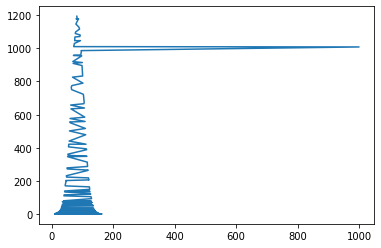

In [58]:
anse.plot()
np.percentile(anse, 95)

Среднее: 457.15584415584414
Медиана: 205.0
Ср. кв. отклонение: 903.993985533452
Мода(моды):
0    2
dtype: int64

Распределение продаж, шт


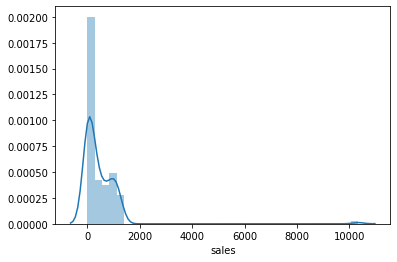

In [59]:
import seaborn
print("Среднее: {0}".format(Sales.mean()))
print("Медиана: {0}".format(Sales.median()))
print("Ср. кв. отклонение: {0}".format(sqrt(Sales.var())))
print("Мода(моды):\n{0}".format(Sales.mode()))
print("\nРаспределение продаж, шт")
seaborn.distplot(Sales)

### 4.Распределение Продаж, шт не нормальное.  Ср. кв. отклонение выборки: 904. В диапазоне 95% лежит 146 значений продаж, на 95 перцентили значение 1125.75

Постройте график распределения количества буквенных размеров ('M', 'L', 'S', 'XL', 'XS', 'XXL', 'XXXL', 'XXS') в выборке

In [61]:
print(general_df['size'].unique()) # посмотрим все значения в столбце Size

['XS' 'S' 'M' 'L' 'XXXL' 'XXL' '28' 'XL' '34' 'XXS' '29' '30' '31' '4XL'
 '26' '33' '27' '32' '38' '0' '25' '36' '40' '35' '54-58' '37'
 'M                        ' 'L                        '
 'S                        ' 'XXL                      '
 'XL                       ' '54-58                    '
 'XXXL                     ' 'no size                  '
 '25-27                    ' '27-29                    '
 '34                       ' '31                       '
 '36                       ' '38                       '
 '30                       ' '32                       '
 '33                       ' 'XS                       '
 '4XL                      ' '40                       '
 '28                       ' '41                       '
 '42                       ' '43                       '
 '44                       ' 'XXS                      '
 '23-25                    ' '37                       '
 '39                       ' '25                       '
 '26     

In [62]:
# выберу заданные значения
Sizes = general_df[general_df.loc[:,"size"].isin(['M', 'L', 'S', 'XL', 'XS', 'XXL', 'XXXL', 'XXS'])]["size"].value_counts()
print(Sizes)

M       9751
L       9695
S       9016
XL      8995
XS      6426
XXL     5558
XXXL    2408
XXS     1029
Name: size, dtype: int64


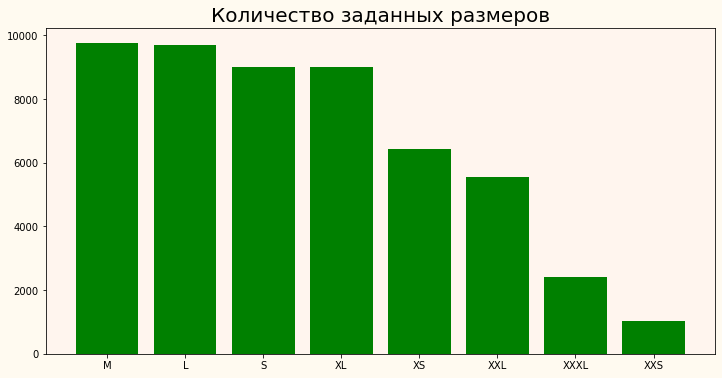

In [63]:
# строю график

fig, ax = plt.subplots()

x = Sizes.index
y = Sizes.values

ax.bar(x, y, color="g")

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.title('Количество заданных размеров', fontsize=20)
plt.show()